### DACON(데이콘) 데이콘 Basic 자동차 가격 예측 AI 경진대회

##### RandomForest 모델 학습

In [206]:
# https://injo.tistory.com/30
# 랜덤 포레스트는 여러 개의 결정트리(Decision Tree)를 활용한 배깅 방식의 대표적인 알고리즘
# 배깅 방식 : 배깅(Bagging)은 Bootstrap Aggregating의 약자로, 보팅(Voting)과는 달리 동일한 
# 알고리즘으로 여러 분류기를 만들어 보팅으로 최종 결정하는 알고리즘

In [212]:
import pandas as pd

preprocess_X = pd.read_csv('preprocessed_data//preprocess_X_data.csv',index_col=0)
preprocess_Y = pd.read_csv('preprocessed_data//preprocess_Y_data.csv',index_col=0) 

In [213]:
preprocess_X

,Year_prd,Year_model,Brand,Model,City,Area,Mileage,CC,Fuel_CNG,Fuel_Diesel,Fuel_Gasoline,Fuel_Hybrid,Fuel_LPG
0,2018,2014,16,47,1214,12,85231,999,0,0,1,0,0
1,2010,2006,17,20,2137,13,135000,1598,0,0,1,0,0
2,2002,2002,9,36,785,15,255223,1796,0,0,1,0,0
3,2006,2001,11,133,546,15,238000,2184,0,1,0,0,0
4,2007,2007,3,25,1839,5,251000,1910,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57915,2017,2011,9,23,1957,15,64839,1461,0,1,0,0,0
57916,2006,2005,12,142,2941,16,299850,1796,0,0,1,0,0
57917,2013,2003,3,90,287,6,112000,1368,0,0,1,0,0
57918,2006,2004,12,19,3174,0,189321,1598,0,0,1,0,0


In [214]:
preprocess_Y

,Price
0,51.74
1,41.47
2,17.81
3,18.20
4,17.55
...,...
57915,116.87
57916,15.47
57917,21.97
57918,16.77


##### 경훈님 전처리 추가

In [215]:
# 1. 주행거리 < 200 (이미 진행)
# 2. ID 컬럼 drop (이미 진행)
# 3. 판매도시 / 판매구역 컬럼drop => 전부 폴란드 도시, 가격선정에 영향이 없을 것으로 판단
# 4. 모델출시년도 drop => 생산연도와 모델출시년도는 0.7이상의 높은 상관관계를 띔 (다중공선성), 하지만 vif 10 이하이면 굳이 제거하지 않음

In [216]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(preprocess_X.values, i) for i in range(preprocess_X.shape[1])]
vif["features"] = preprocess_X.columns
vif

,VIF Factor,features
0,5.873068,Year_prd
1,5.040302,Year_model
2,1.150287,Brand
3,1.067128,Model
4,1.004029,City
5,1.004837,Area
6,2.143119,Mileage
7,1.310855,CC
8,160.756735,Fuel_CNG
9,140226.915349,Fuel_Diesel


##### Fuel 컬럼 통일

In [218]:
def column_fuel(Data):

    Data['Fuel'] = 0

    fuel_types = ['Fuel_CNG','Fuel_Diesel','Fuel_Gasoline','Fuel_Hybrid','Fuel_LPG']

    fuel_idx = 0
    for fuel_type in fuel_types:
        Data.loc[Data[fuel_type]==1,'Fuel'] = fuel_idx
        fuel_idx += 1

    return Data

preprocess_X = column_fuel(preprocess_X)

In [219]:
preprocess_X.sample(15)

,Year_prd,Year_model,Brand,Model,City,Area,Mileage,CC,Fuel_CNG,Fuel_Diesel,Fuel_Gasoline,Fuel_Hybrid,Fuel_LPG,Fuel
32585,2017,2011,17,141,2286,11,193590,1497,0,0,0,1,0,3
13827,2007,2006,7,31,2596,15,220000,1998,0,0,0,0,1,4
7948,2017,2015,1,134,3099,4,73000,1995,0,1,0,0,0,1
29127,2009,2008,14,74,664,13,241200,1998,0,0,0,0,1,4
36656,2013,2012,1,104,1953,0,270000,1995,0,1,0,0,0,1
53774,1995,1995,0,9,742,11,252000,1781,0,0,0,0,1,4
25744,2014,2010,4,49,1469,3,103100,1999,0,0,1,0,0,2
19904,2008,2005,1,104,968,13,170000,1995,0,0,1,0,0,2
46571,2006,2004,12,19,1744,6,226000,1598,0,0,1,0,0,2
26351,2018,2013,16,79,742,11,120132,1968,0,1,0,0,0,1


In [220]:
preprocess_X = preprocess_X.drop(columns=['Fuel_CNG','Fuel_Diesel','Fuel_Gasoline','Fuel_Hybrid','Fuel_LPG'])

In [221]:
preprocess_X

,Year_prd,Year_model,Brand,Model,City,Area,Mileage,CC,Fuel
0,2018,2014,16,47,1214,12,85231,999,2
1,2010,2006,17,20,2137,13,135000,1598,2
2,2002,2002,9,36,785,15,255223,1796,2
3,2006,2001,11,133,546,15,238000,2184,1
4,2007,2007,3,25,1839,5,251000,1910,1
...,...,...,...,...,...,...,...,...,...
57915,2017,2011,9,23,1957,15,64839,1461,1
57916,2006,2005,12,142,2941,16,299850,1796,2
57917,2013,2003,3,90,287,6,112000,1368,2
57918,2006,2004,12,19,3174,0,189321,1598,2


In [222]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(preprocess_X.values, i) for i in range(preprocess_X.shape[1])]
vif["features"] = preprocess_X.columns
vif

,VIF Factor,features
0,787249.927995,Year_prd
1,787952.384484,Year_model
2,3.614214,Brand
3,3.783200,Model
4,4.541265,City
5,3.531718,Area
6,6.657596,Mileage
7,15.025367,CC
8,6.629283,Fuel


##### Train / Test 데이터 분할

In [223]:
from sklearn.model_selection import train_test_split

X_train, X_test , y_train , y_test = train_test_split(preprocess_X,preprocess_Y,test_size=0.2,random_state=777)

In [224]:
X_train.shape , y_train.shape

((45359, 9), (45359, 1))

In [225]:
X_test.shape , y_test.shape

((11340, 9), (11340, 1))

##### 모델 학습

In [226]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=777)

rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)

C:\Users\user\AppData\Local\Temp\ipykernel_19916\4211305117.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train,y_train)


##### 평가지표 : MAE, MSE, RMSE, MAPE

In [227]:
# 실제 정답 값과 예측 값의 차이를 절댓값으로 변환한 뒤 합산하여 평균을 구한다.
# 특이값이 많은 경우에 주로 사용된다.
# 값이 낮을수록 좋다.

#장점
#직관점임
#정답 및 예측 값과 같은 단위를 가짐

#단점
#실제 정답보다 낮게 예측했는지, 높게 했는지를 파악하기 힘듦
#스케일 의존적임(scal dependency): 모델마다 에류 크기가 동일해도 에러율은 동일하지 않음

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test,y_pred)
mae

6.110908308788948

In [228]:
# MSE(Mean Squared Error) = 평균 제곱 오차
# 실제 정답 값과 예측 값의 차이를 제곱한 뒤 평균을 구한다.
# 값이 낮을수록 좋다.

# 장점
# 직관적임

# 단점
# 제곱하기 때문에 1미만의 에러는 작아지고, 그 이상의 에러는 커짐
# 실제 정답보다 낮게 예측했는지, 높게 했는지를 파악하기 힘듦
# 스케일 의존적임(scal dependency): 모델마다 에류 크기가 동일해도 에러율은 동일하지 않음

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test,y_pred)
mse

88.09372790678268

In [229]:
# RMSE(Root Mean Squared Error) = 평균 제곱근 오차
# MSE에 루트는 씌워서 에러를 제곱해서 생기는 값의 왜곡이 줄어든다.

# 값이 낮을수록 좋다.

# 장점
# 직관적임

# 단점
# 제곱하기 때문에 1미만의 에러는 작아지고, 그 이상의 에러는 커짐
# 실제 정답보다 낮게 예측했는지, 높게 했는지를 파악하기 힘듦
# 스케일 의존적임(scal dependency): 모델마다 에류 크기가 동일해도 에러율은 동일하지 않음


from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
rmse

9.385825904350808

In [230]:
# R2 score = R squard
# 다른 지표(MAE, MSE, RMSE)들은 모델마다 값이 다르기 때문에 절대 값만 보고 선능을 판단하기 어렵다.
# R2 score는 상대적인 성능을 나타내기 비교가 쉽다.
# 실제 값의 분산 대비 예측값의 분산 비율을 의미한다.
# 1에 가까울 수록 좋다.

from sklearn.metrics import r2_score

r2 = r2_score(y_test,y_pred)
r2

0.9273831968065547

In [231]:
def regression_eval(y_test,y_pred):

    from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    print("mae : ", mae)
    print("mse : ", mse)
    print("rmse : ", rmse)
    print("r2 : ", r2)


    return mae , mse , rmse , r2


mae , mse , rmse , r2 = regression_eval(y_test,y_pred)

mae :  6.110908308788948
mse :  88.09372790678268
rmse :  9.385825904350808
r2 :  0.9273831968065547


In [232]:
evals = {'CV':'-','Mae':mae,'Mse':mse,'Rmse':rmse,'R2':r2}
evals

{'CV': '-',
 'Mae': 6.110908308788948,
 'Mse': 88.09372790678268,
 'Rmse': 9.385825904350808,
 'R2': 0.9273831968065547}

##### Feature Importances (피처중요도)

In [233]:
rfr.feature_importances_ , preprocess_X.columns

(array([0.61938506, 0.03524713, 0.02846062, 0.04504199, 0.01709717,
        0.01129425, 0.05038283, 0.18636764, 0.00672331]),
 Index(['Year_prd', 'Year_model', 'Brand', 'Model', 'City', 'Area', 'Mileage',
        'CC', 'Fuel'],
       dtype='object'))

In [234]:
df_feature_importances = pd.DataFrame({'Features':preprocess_X.columns,'Importances':rfr.feature_importances_})
df_feature_importances

,Features,Importances
0,Year_prd,0.619385
1,Year_model,0.035247
2,Brand,0.028461
3,Model,0.045042
4,City,0.017097
5,Area,0.011294
6,Mileage,0.050383
7,CC,0.186368
8,Fuel,0.006723


In [235]:
df_feature_importances = df_feature_importances.sort_values('Importances',ascending=False)

<Axes: xlabel='Importances', ylabel='Features'>

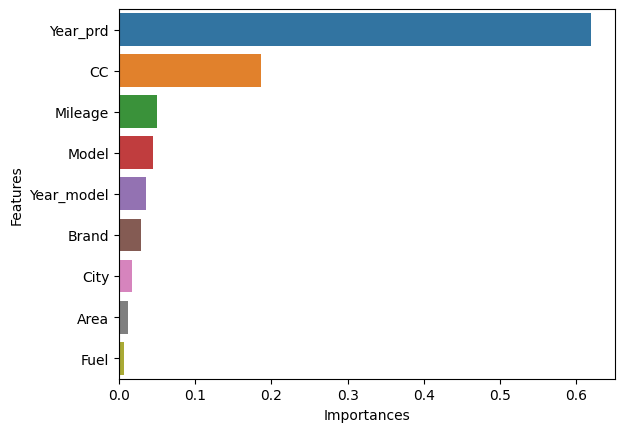

In [236]:
import seaborn as sns

sns.barplot(x='Importances',y='Features',data=df_feature_importances)

##### K-FOLD 교차 검증 학습 

In [237]:
import pandas as pd

preprocess_X = pd.read_csv('preprocessed_data//preprocess_X_data.csv',index_col=0)
preprocess_Y = pd.read_csv('preprocessed_data//preprocess_Y_data.csv',index_col=0) 

In [238]:
from sklearn.model_selection import KFold

def exec_kfold(preprocess_X,preprocess_Y,folds=5):

    from sklearn.ensemble import RandomForestRegressor
    import numpy as np

    rfr = RandomForestRegressor(random_state=777)

    kfold = KFold(n_splits=folds)
    evals = dict({'Mae':[],'Mse':[],'Rmse':[],'R2':[]})
    mean_evals = dict({'Mae':[],'Mse':[],'Rmse':[],'R2':[]})
    
    # KFold 교차 검증 수행
    for iter_count , (train_index, test_index) in enumerate(kfold.split(preprocess_X)):

        print(str(iter_count+1) + "번째 fold")
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = preprocess_X.values[train_index], preprocess_X.values[test_index]
        y_train, y_test = preprocess_Y.values[train_index], preprocess_Y.values[test_index]
        
        # 회귀 모델 학습, 예측 
        rfr.fit(X_train, y_train) 
        y_pred = rfr.predict(X_test)

        # mae, mse, rmse, r2 
        mae , mse , rmse , r2 = regression_eval(y_test,y_pred)

        evals['Mae'].append(mae)
        evals['Mse'].append(mse)
        evals['Rmse'].append(rmse)
        evals['R2'].append(r2)

    mean_evals['CV'] = 'KFOLD = ' + str(folds) +'(mean)'
    for key in evals.keys():
        print("평균 ",key, " : ", np.mean(evals[key]))
        # mean_evals['Mean_'+key] = np.mean(evals[key])
        mean_evals[key] = np.mean(evals[key])

    return mean_evals

# exec_kfold 호출
mean_evals = exec_kfold(preprocess_X,preprocess_Y,folds=5) 

1번째 fold


C:\Users\user\AppData\Local\Temp\ipykernel_19916\590911768.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


mae :  6.343393655496766
mse :  100.5305728725529
rmse :  10.026493548222772
r2 :  0.9162255084014297
2번째 fold


C:\Users\user\AppData\Local\Temp\ipykernel_19916\590911768.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


mae :  6.098661558117073
mse :  90.26975372106796
rmse :  9.501039612645974
r2 :  0.9247484170741176
3번째 fold


C:\Users\user\AppData\Local\Temp\ipykernel_19916\590911768.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


mae :  6.192179251490719
mse :  91.42426142317173
rmse :  9.561603496441991
r2 :  0.9239497297236114
4번째 fold


C:\Users\user\AppData\Local\Temp\ipykernel_19916\590911768.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


mae :  6.095766648945998
mse :  88.75170624999183
rmse :  9.420812398619974
r2 :  0.9244480036078465
5번째 fold


C:\Users\user\AppData\Local\Temp\ipykernel_19916\590911768.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


mae :  6.1826165090144
mse :  90.86922669759679
rmse :  9.532535166344617
r2 :  0.9231707438541896
평균  Mae  :  6.182523524612991
평균  Mse  :  92.36910419287624
평균  Rmse  :  9.608496844455065
평균  R2  :  0.9225084805322389


##### No Cross Validation vs Cross Validation 평가 지표 비교

In [239]:
import pandas as pd

df_evals = pd.DataFrame(evals,index=[0])
df_evals

,CV,Mae,Mse,Rmse,R2
0,-,6.110908,88.093728,9.385826,0.927383


In [240]:
df_mean_evals= pd.DataFrame(mean_evals,index=[0])
df_mean_evals = df_mean_evals[['CV','Mae','Mse','Rmse','R2']]
df_mean_evals

,CV,Mae,Mse,Rmse,R2
0,KFOLD = 5(mean),6.182524,92.369104,9.608497,0.922508


##### GridSearchcv 하이퍼 파라미터 조정

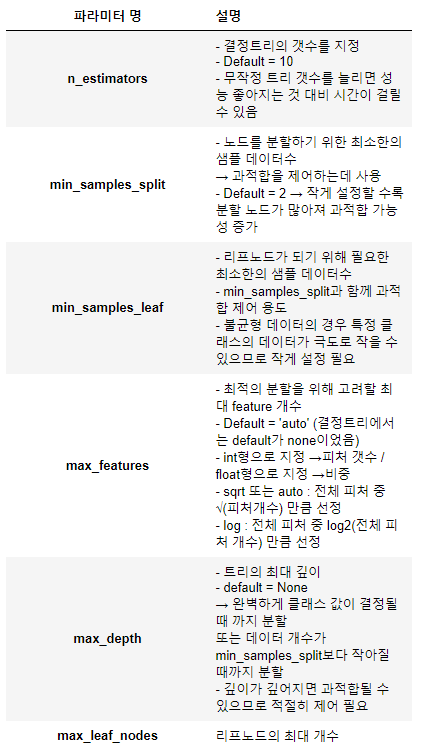

In [ ]:
# params_grid = { 'n_estimators' : [100,200],
#            'max_depth' : [6, 8, 10, 12],
#            'min_samples_leaf' : [8, 12, 18],
#            'min_samples_split' : [8, 16, 20]
#             }

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import numpy as np
import time
import warnings


warnings.filterwarnings(action='ignore')

rfr = RandomForestRegressor(random_state=777)

preprocess_X = pd.read_csv('preprocessed_data//preprocess_X_data.csv',index_col=0)
preprocess_Y = pd.read_csv('preprocessed_data//preprocess_Y_data.csv',index_col=0) 

X_train, X_test , y_train , y_test = train_test_split(preprocess_X,preprocess_Y,test_size=0.2,random_state=777)

scorings = ['neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error','r2']
# param_grid = { 
#         "n_estimators"      : [5,10,15,20,25,30],
#         "max_features"      : ["auto", "sqrt", "log2"],
#         "max_depth" : [1,2,3,4],
#         'max_leaf_nodes': [None,2,4,6,8], 
#         "min_samples_split" : [2,4,6,8],
#         'min_samples_leaf':[2,4,6,8], 
#         # "bootstrap": [True, False],
#         }

params_grid = { 'n_estimators' : [100,200],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

start = time.time()

for scoring in scorings:

    print("----------- scoring type : ", scoring," ----------- ")

    # n_jobs = -1 모든 CPU 코어 사용
    grid_rfr = GridSearchCV(rfr, 
                            param_grid=params_grid , 
                            scoring=scoring, 
                            cv=5,
                            n_jobs=-1)
    
    grid_rfr.fit(X_train , y_train)

    print('GridSearchCV 최적 하이퍼 파라미터 :',grid_rfr.best_params_)
    print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_rfr.best_score_))
    best_dclf = grid_rfr.best_estimator_

    # GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
    y_pred = best_dclf.predict(X_test)

    if scoring == 'neg_mean_absolute_error':
        mae = mean_absolute_error(y_test , y_pred)
        print('테스트 세트에서의 RandomForestRegressor mae : ', mae)
    elif scoring == 'neg_mean_squared_error':
        mse = mean_squared_error(y_test , y_pred)
        print('테스트 세트에서의 RandomForestRegressor mse : ', mse)
    elif scoring == 'neg_root_mean_squared_error':
        rmse = np.sqrt(mean_squared_error(y_test , y_pred))
        print('테스트 세트에서의 RandomForestRegressor rmse : ', rmse)
    else:
        r2 = r2_score(y_test , y_pred)
        print('테스트 세트에서의 RandomForestRegressor r2 : ', r2)

print("GridSearchcv 소요시간 : ", time.time()-start)

In [ ]:
# params_grid = { 'n_estimators' : [200,300,400],
#            'max_depth' : [6, 8, 10, 12],
#            'min_samples_leaf' : [8, 12, 18],
#            'min_samples_split' : [8, 16, 20]
#             }

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import numpy as np
import time
import warnings


warnings.filterwarnings(action='ignore')

rfr = RandomForestRegressor(random_state=777)

preprocess_X = pd.read_csv('preprocessed_data//preprocess_X_data.csv',index_col=0)
preprocess_Y = pd.read_csv('preprocessed_data//preprocess_Y_data.csv',index_col=0) 

X_train, X_test , y_train , y_test = train_test_split(preprocess_X,preprocess_Y,test_size=0.2,random_state=777)

scorings = ['neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error','r2']
# param_grid = { 
#         "n_estimators"      : [5,10,15,20,25,30],
#         "max_features"      : ["auto", "sqrt", "log2"],
#         "max_depth" : [1,2,3,4],
#         'max_leaf_nodes': [None,2,4,6,8], 
#         "min_samples_split" : [2,4,6,8],
#         'min_samples_leaf':[2,4,6,8], 
#         # "bootstrap": [True, False],
#         }

params_grid = { 'n_estimators' : [200,300,400],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

start = time.time()

for scoring in scorings:

    print("----------- scoring type : ", scoring," ----------- ")

    # n_jobs = -1 모든 CPU 코어 사용
    grid_rfr = GridSearchCV(rfr, 
                            param_grid=params_grid , 
                            scoring=scoring, 
                            cv=5,
                            n_jobs=-1)
    
    grid_rfr.fit(X_train , y_train)

    print('GridSearchCV 최적 하이퍼 파라미터 :',grid_rfr.best_params_)
    print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_rfr.best_score_))
    best_dclf = grid_rfr.best_estimator_

    # GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
    y_pred = best_dclf.predict(X_test)

    if scoring == 'neg_mean_absolute_error':
        mae = mean_absolute_error(y_test , y_pred)
        print('테스트 세트에서의 RandomForestRegressor mae : ', mae)
    elif scoring == 'neg_mean_squared_error':
        mse = mean_squared_error(y_test , y_pred)
        print('테스트 세트에서의 RandomForestRegressor mse : ', mse)
    elif scoring == 'neg_root_mean_squared_error':
        rmse = np.sqrt(mean_squared_error(y_test , y_pred))
        print('테스트 세트에서의 RandomForestRegressor rmse : ', rmse)
    else:
        r2 = r2_score(y_test , y_pred)
        print('테스트 세트에서의 RandomForestRegressor r2 : ', r2)

print("GridSearchcv 소요시간 : ", time.time()-start)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import numpy as np
import time
import warnings


warnings.filterwarnings(action='ignore')

rfr = RandomForestRegressor(random_state=777)

preprocess_X = pd.read_csv('preprocessed_data//preprocess_X_data.csv',index_col=0)
preprocess_Y = pd.read_csv('preprocessed_data//preprocess_Y_data.csv',index_col=0) 

X_train, X_test , y_train , y_test = train_test_split(preprocess_X,preprocess_Y,test_size=0.2,random_state=777)

scorings = ['neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error','r2']
# param_grid = { 
#         "n_estimators"      : [5,10,15,20,25,30],
#         "max_features"      : ["auto", "sqrt", "log2"],
#         "max_depth" : [1,2,3,4],
#         'max_leaf_nodes': [None,2,4,6,8], 
#         "min_samples_split" : [2,4,6,8],
#         'min_samples_leaf':[2,4,6,8], 
#         # "bootstrap": [True, False],
#         }

params_grid = { 'n_estimators' : [600,800,1000],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [4,8,12,16],
           'min_samples_split' : [4,8,12,16]
            }

start = time.time()

for scoring in scorings:

    print("----------- scoring type : ", scoring," ----------- ")

    # n_jobs = -1 모든 CPU 코어 사용
    grid_rfr = GridSearchCV(rfr, 
                            param_grid=params_grid , 
                            scoring=scoring, 
                            cv=5,
                            n_jobs=-1)
    
    grid_rfr.fit(X_train , y_train)

    print('GridSearchCV 최적 하이퍼 파라미터 :',grid_rfr.best_params_)
    print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_rfr.best_score_))
    best_dclf = grid_rfr.best_estimator_

    # GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
    y_pred = best_dclf.predict(X_test)

    if scoring == 'neg_mean_absolute_error':
        mae = mean_absolute_error(y_test , y_pred)
        print('테스트 세트에서의 RandomForestRegressor mae : ', mae)
    elif scoring == 'neg_mean_squared_error':
        mse = mean_squared_error(y_test , y_pred)
        print('테스트 세트에서의 RandomForestRegressor mse : ', mse)
    elif scoring == 'neg_root_mean_squared_error':
        rmse = np.sqrt(mean_squared_error(y_test , y_pred))
        print('테스트 세트에서의 RandomForestRegressor rmse : ', rmse)
    else:
        r2 = r2_score(y_test , y_pred)
        print('테스트 세트에서의 RandomForestRegressor r2 : ', r2)

print("GridSearchcv 소요시간 : ", time.time()-start)